<a href="https://colab.research.google.com/github/yukiya06/E-commerce_DataAnalysis/blob/main/Instacart_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 'Instacart' **재주문**을 늘리기 위한 **마케팅 인사이트** 도출

# 0. 기본세팅

In [ ]:
#한글폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#런타임 재시작

In [1]:
#필요 라이브러리 세팅
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # 천단위 콤마 표시(y축)
import seaborn as sns
import plotly.express as px
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')
import psutil

%matplotlib inline
plt.rc('font', family='NanumBarunGothic') #한글폰트 에러방지



---



#1. 주제 선정 이유 및 자료 구성

## 1.1 주제 선정 이유
* 인스타카트는 온라인 식료품 구매 서비스를 제공하는, **성장** 동력을 얻기 시작한 인기 앱입니다. **신규 고객 유치**에 한창이지만, **재주문**을 하는 고객들도 중요하다는 조언을 받았습니다. 
* 신규 고객을 확보하는 데는 기존 고객을 유지하는 것보다 훨씬 많은 비용이 소요됩니다. 많은 연구에 따르면 **재주문 고객이 기업 매출의 40% 이상 창출**<sup>[1]</sup> 할 수 있고, **고객 유지율을 5%증가시킬 때 수익이 25~95% 증가**<sup>[2]</sup> 할 수 있습니다. 따라서 **반복적인 재주문을 장려**하고 **고객을 유지**하는 방법에 대한 분석이 필요합니다.
(참고자료 1. [Adobe Digital Index](https://www.adobe.com/ca/experience-cloud/digital-insights/digital-economy-index.html), 2. [Harvard Business Review](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers))


## 1.2 분석의 목적
* **목적**: **재주문을 장려하기 위한 마케팅 인사이트 도출**  
* **문제 정의(가설 설정)**: **재주문에는 패턴이 있다.**  
    - 주문 시점, 주문 횟수, 주문하는 상품 수, 주문 상품 구성에 특징이 있다.
    - 해당 패턴을 파악하고, 재주문을 장려하기 위한 마케팅 인사이트를 도출한다.

- **재주문**이란? : **기존 고객의 재구매**를 의미합니다. 이 고객들은 해당 기업을 잘 알고 있으며, 편하기 때문에 같은 곳에서 반복적으로 구매를 하는 편입니다.  신규 고객처럼 다양한 상품을 탐색하고, 비교하지 않고, 원하는 것을 이미 알고 있으니 그 상품을 바로 구매합니다.

## 1.3 자료구성
* 선정데이터: [Instacart Orders 오픈소스 데이터](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) 
* 데이터셋 상세 설명: https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b
* **총 20만명** 고객의 **340만 건** 주문내역에 대한 데이터 입니다.
* 크게 **주문정보, 상품정보**로 구분되며, **하나의 주문시 포함된 상품 목록들이 연결**된 데이터 입니다.
* 이전 주문은 prior, 마지막 주문은 train 또는 test(제출용 파일)로 구분되어 있습니다. 통합하여 사용합니다.
* **데이터 테이블 연결구조**는 아래와 같습니다.

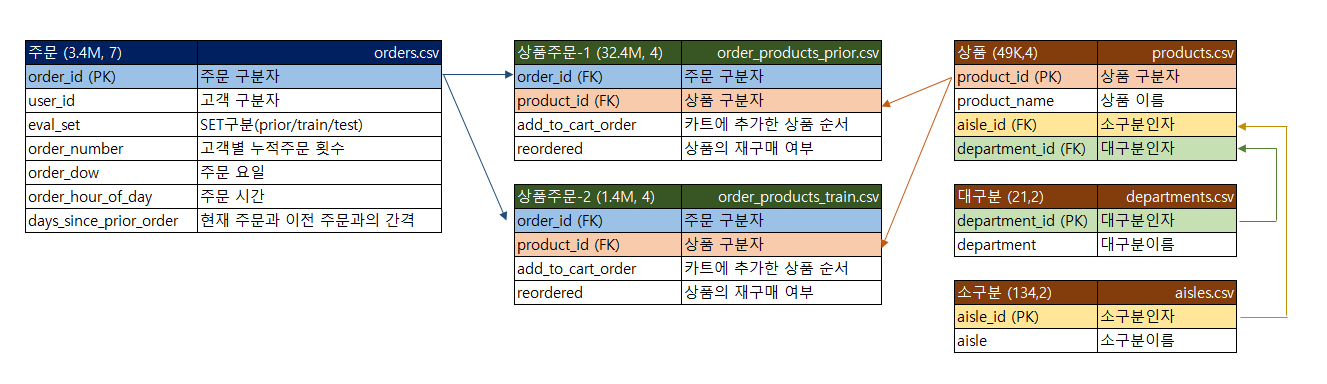

In [2]:
# 사용파일
#prior = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/order_products__prior.csv')
#train = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/order_products__train.csv')

order_products = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/order_products.csv') #prior + train
order_products = order_products.drop('Unnamed: 0', axis=1)
orders = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/orders.csv', index_col=0) #오더번호당 주문상품수 하단에서 추가
products = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/products.csv')
aisles = pd.read_csv("/content/drive/MyDrive/AI09_Pjt/cp1/instacart/aisles.csv")
departments = pd.read_csv("/content/drive/MyDrive/AI09_Pjt/cp1/instacart/departments.csv")

In [ ]:
print("주문상품 수량: ", f'{int(order_products.shape[0]) :,}', "건")
print("주문 집계: ", f'{int(orders.shape[0]) :,}', "건")
print("---------------------------------------")
print("상품목록: ", f'{int(products.shape[0]) :,}', "개")
print("대분류: ", f'{int(departments.shape[0]) :,}', "개")
print("소분류: ", f'{int(aisles.shape[0]) :,}', "개")

주문상품 수량:  33,819,106 건
주문 집계:  3,346,083 건
---------------------------------------
상품목록:  49,688 개
대분류:  21 개
소분류:  134 개


## 1.4 사용 기술 및 구현 내용
* 필요한 데이터를 정의 및 수집하여 이를 분석하는 전체 프로세스를 따라 진행 하였습니다.
* 사용한 기술 및 구현 내용은 아래와 같습니다.

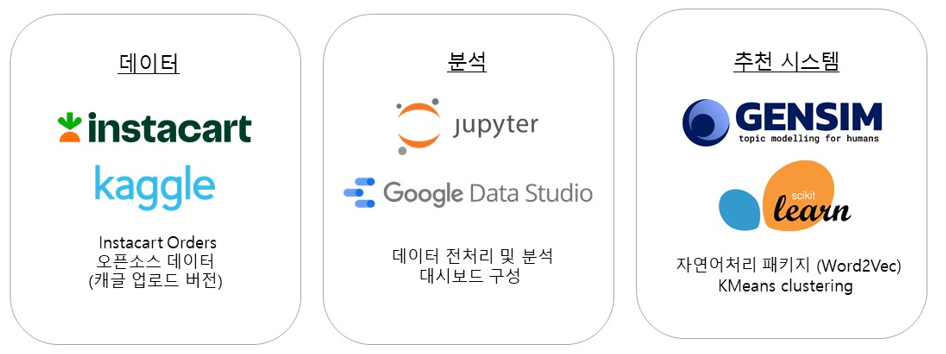

## 1.5 프로젝트 진행 일정
* 총 10일 일정으로 (일부 주말 제외) 간단한 진행 내용은 아래와 같습니다.

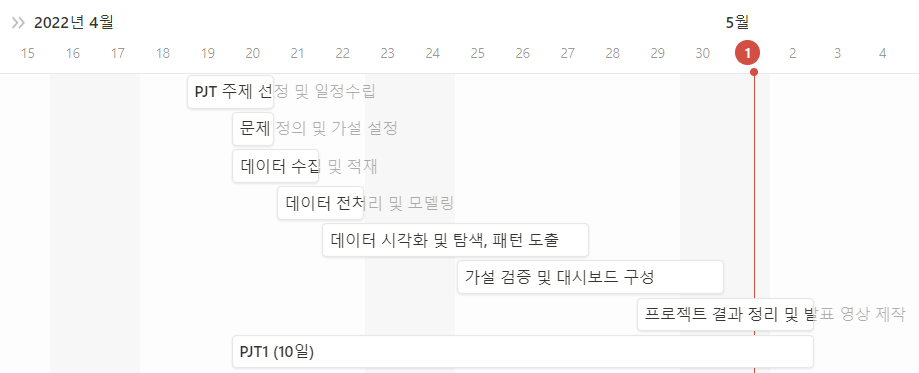

# 2. 탐색적 자료 분석 (EDA)

* 데이터 시각화와 기술통계를 통해 **사업현황을 파악**하고, **예상한 가설을 검증**합니다.
    * 사업현황 파악: ① 주문 **고객** 분석, ② 주문 **상품** 분석
    * 프로젝트 가설 검증:  
        **재주문**에 **패턴**이 존재한다. (주문 시점, 주문 횟수, 주문하는 상품 수, 주문 상품 구성)

## 2.0 사용 파일 생성

In [3]:
## 주문상품파일 (order_total)
# order_total = pd.merge(order_products, orders, on='order_id')
# order_total = pd.merge(order_total,products, on='product_id')
# order_total = pd.merge(order_total,aisles, on ='aisle_id')
# order_total = pd.merge(order_total,departments, on ='department_id') #모든 정보 통합, 여기서 추출해서 사용

order_total = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/cp1/instacart/order_total.csv', index_col=0)

In [4]:
with open('/content/drive/MyDrive/AI09_Pjt/cp1/treemap.pkl','rb') as f:
    treemap = pickle.load(f)

## 2.1 사업 현황 파악

### 2.1.1 주문 고객 분석

In [ ]:
total_user = len(orders.user_id.unique())
total_order = len(orders)

print("총 구매자 수: ", f'{total_user:,}', '명')
print("전체 주문 수: ", f'{total_order:,}', '건')
print("유저당 평균 주문 수: ", f'{total_order/total_user:,.2f}', '건')

총 구매자 수:  206,209 명
전체 주문 수:  3,346,083 건
유저당 평균 주문 수:  16.23 건


#### 2.1.1 - 1 고객별 **누적 주문 횟수**는?
* **4번 이용**한 고객이 가장 많고, 5번 부터 감소합니다. (그래프 참조)
    * 단순히 계산한 유저당 평균 주문 수(16건)가 더 높은데, 이는 **재주문을 자주 하는 고객의 사용빈도가 높아 평균이 증가했습니다.**
* **10회 이하로 이용한 고객이 52%**,  20회대 24%,  30회대 구매자가 10% 비중을 차지 합니다. **40회 이상** 구매한 파워유저는 **9%**를 차지합니다.  



* 3회 이상 구매한 고객 데이터만 포함하므로, 1~2회 구매후 재이용 안하는 고객정보는 알 수 없습니다. 이용 고객의 특성이나 추가로 공개된 내용이 없어 고객 성향에 따른 구매패턴 예측은 어렵습니다. 따라서 함께 구매했던 **상품을 중심으로 추가 분석**을 진행하고자 합니다. 

In [ ]:
order_last = orders.drop_duplicates(['user_id'],keep='last')

In [ ]:
# order_sum_pt = orders.pivot_table(index='user_id', columns='order_number', values='order_id', aggfunc=len, margins=True).fillna(0)
# order_sum_pt.iloc[-1][4]

In [ ]:
cum_order = order_last.order_number.value_counts().reset_index(drop=False)
cum_order.columns = [['누적주문 횟수','user']]
cum_order['%'] = round(cum_order['user']/ cum_order['user'].sum(),3)*100
cum_order[:8]

,누적주문 횟수,user,%
0,4,22451,10.9
1,5,18267,8.9
2,6,15334,7.4
3,7,13196,6.4
4,8,11075,5.4
5,9,9762,4.7
6,3,8686,4.2
7,10,8660,4.2


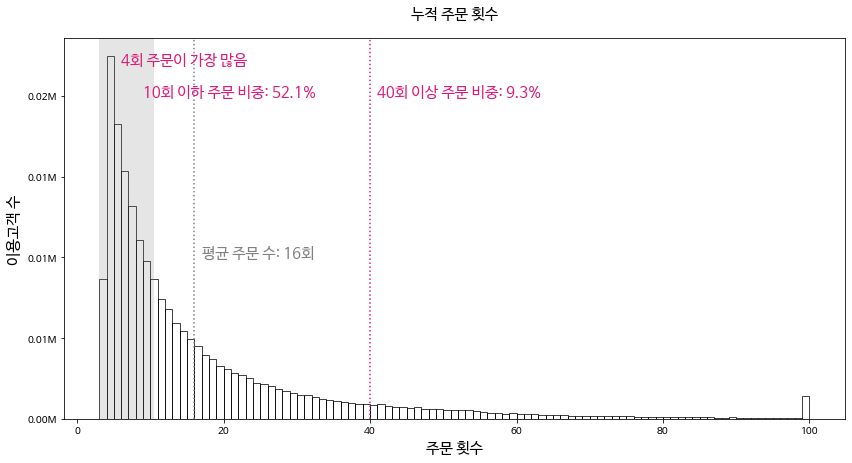

In [ ]:
plt.figure(figsize=(14,7))
g= sns.histplot(data=order_last, x="order_number", binwidth=1, fill=False, color='black');
ylabels =  ['{:,.2f}'.format(y) + 'M' for y in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)
plt.axvline(x=40, linestyle=':', color='#dd1c77');
plt.axvline(x=16, linestyle=':', color='gray');

plt.title('누적 주문 횟수', fontsize=15, pad=20);
plt.xlabel('주문 횟수', fontsize=15);
plt.ylabel('이용고객 수', fontsize=15);
plt.axvspan(3, 10.5, facecolor='gray', alpha=0.2);
plt.text(6, 22000, '4회 주문이 가장 많음', color='#dd1c77', fontsize=15);
plt.text(9, 20000, '10회 이하 주문 비중: 52.1%', color='#dd1c77', fontsize=15);
plt.text(17, 10000, '평균 주문 수: 16회', color='gray', fontsize=15);
plt.text(41, 20000, '40회 이상 주문 비중: 9.3%', color='#dd1c77', fontsize=15);

In [ ]:
user_sum_10 = cum_order['%'][:8].sum()
user_sum_20 = cum_order['%'][8:18].sum()
user_sum_30 = cum_order['%'][18:28].sum()
user_sum_40 = cum_order['%'][28:38].sum()
user_sum_end = cum_order['%'][37:].sum()
user_sum_list = [user_sum_10,user_sum_20,user_sum_30,user_sum_40,user_sum_end]
for i in user_sum_list:
    print(round(i[0],2))

52.1
23.8
10.2
5.3
9.3


### 2.1.2 **주문 상품 분석**

In [5]:
total_ordered_product = len(order_products)
unique_products = len(products.product_id)
reordered_product = len(order_products[order_products['reordered']==1])

print("총 판매 상품 종류: ", f'{unique_products:,}', '개')
print("총 판매된 상품 수량: ", f'{total_ordered_product:,}', '개')
print("상품당 평균 주문 수: ", f'{total_ordered_product/unique_products:,.2f}', '개')
print('------------------------------------------------------')
print("판매 상품 중 재주문 상품의 비중: ", f'{reordered_product/total_ordered_product*100: ,.2f}','%')

총 판매 상품 종류:  49,688 개
총 판매된 상품 수량:  33,819,106 개
상품당 평균 주문 수:  680.63 개
------------------------------------------------------
판매 상품 중 재주문 상품의 비중:   59.01 %


#### 2.1.2 - 1 한번의 주문에 **주문한 상품의 갯수**는?
* **4~7가지**의 종류를 주문하는 고객이 가장 많습니다. (전체의 약 30% 차지)
* **10가지 이하**로 구매하는 고객이 **전체의 62%**, **30종류 이하 주문**은 **전체의 98%** 입니다.

In [ ]:
order_num_p = orders[['order_id','product_cnt']] #주문당 포함된 상품수

In [ ]:
sum(order_num_p.product_cnt)/len(order_num_p.order_id)

10.10707325550502

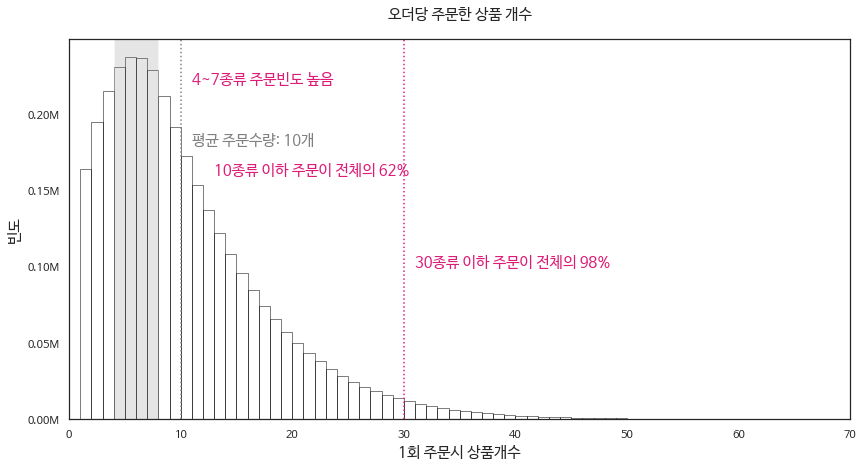

In [ ]:
plt.figure(figsize=(14,7))
g= sns.histplot(data=order_num_p, x="product_cnt", binwidth=1, fill=False, color='black');
sns.set(style="white",  rc={'font.family':'NanumBarunGothic'})
ylabels =  ['{:,.2f}'.format(y) + 'M' for y in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)
plt.xlim(0,70)

plt.title('오더당 주문한 상품 개수', fontsize=15, pad=20);
plt.xlabel('1회 주문시 상품개수', fontsize=15);
plt.ylabel('빈도', fontsize=15);

plt.axvspan(4, 8, facecolor='gray', alpha=0.2);
plt.text(11, 220000, '4~7종류 주문빈도 높음', color='#dd1c77', fontsize=15);
plt.text(13, 160000, '10종류 이하 주문이 전체의 62%', color='#dd1c77', fontsize=15);
plt.text(31, 100000, '30종류 이하 주문이 전체의 98%', color='#dd1c77', fontsize=15);
plt.text(11, 180000, '평균 주문수량: 10개', color='gray', fontsize=15);
plt.axvline(x=10, linestyle=':', color='gray');
plt.axvline(x=30, linestyle=':', color='#dd1c77');

In [ ]:
order_num = order_num_p['product_cnt'].value_counts(ascending=False).reset_index(drop=False)
order_num.columns = [['주문한 상품수','cnt']]
order_num['%'] = round(order_num['cnt']/ order_num['cnt'].sum(),3)*100
order_num[:10]

,주문한 상품수,cnt,%
0,5,237225,7.1
1,6,236383,7.1
2,4,230299,6.9
3,7,228547,6.8
4,3,215060,6.4
5,8,211357,6.3
6,2,194361,5.8
7,9,191564,5.7
8,10,172103,5.1
9,1,163593,4.9


In [ ]:
sum_5 = order_num['%'][:5].sum()
sum_10 = order_num['%'][:10].sum()
sum_30 = order_num['%'][:30].sum()
sum_list = [sum_5,sum_10,sum_30]
for i in sum_list:
    print(round(i[0],2))

34.3
62.1
97.7


#### 2.1.2 - 2 상품 **대분류**, **소분류** 매출 순위
* Treemap을 통해 상품을 대분류, 소분류를 함께 시각화 하였습니다.
* **박스의 크기**가 매출된 **수량 차이**를 나타냅니다. 크기가 큰 박스가 비중이 크다고 직관적으로 알 수 있습니다.
* **농산물**(야채와 과일) 비중이 크며, 그다음은 **유제품**(요거트,우유,치즈), **스낵**과 **음료** 순으로 판매수량이 많습니다.

In [ ]:
fig = px.treemap(treemap, path=[px.Constant("Sales Products"), 'department', 'aisle'], values='total_cnt',
                 color='department', color_continuous_scale='RdBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
treemap.pivot_table(index='department', columns='aisle', values='total_cnt',aggfunc=sum, margins=True).fillna(0).sort_values(by='All', ascending=False).head(5)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,All
department,,,,,,,,,,,,,,,,,,,,,
All,20918.0,173614.0,8466.0,8909.0,395654.0,36372.0,339780.0,24786.0,6455.0,50496.0,...,258717.0,134597.0,201650.0,37053.0,33702.0,47028.0,878150.0,31646.0,1507583.0,33819106
produce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9888378
dairy eggs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1507583.0,5631067
snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,37053.0,0.0,0.0,0.0,0.0,0.0,3006412
beverages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,258717.0,0.0,0.0,0.0,0.0,0.0,878150.0,0.0,0.0,2804175


#### 2.1.2 - 3 가장 **많이 판매**되는 상품 TOP 10 (품명, 판매수량)
* 바나나가 1위이며, 상품종류가 많으므로 상위 판매상품도 각 상품이 전체매출에서 차지하는 비중은 1%대로 적습니다.
* 단일 품목이 수량 측면에서는 매출에 대부분을 차지하고 있지는 않습니다.

In [ ]:
top10 = order_total.product_name.value_counts().reset_index(drop=False)
top10.columns = [['product_name','product_cnt']]
top10['%'] = round(top10['product_cnt']/ top10['product_cnt'].sum(),3)*100
top10[:10]

,product_name,product_cnt,%
0,Banana,491291,1.5
1,Bag of Organic Bananas,394930,1.2
2,Organic Strawberries,275577,0.8
3,Organic Baby Spinach,251705,0.7
4,Organic Hass Avocado,220877,0.7
5,Organic Avocado,184224,0.5
6,Large Lemon,160792,0.5
7,Strawberries,149445,0.4
8,Limes,146660,0.4
9,Organic Whole Milk,142813,0.4


#### 2.1.2 - 4 카트에 **첫 번째로 담기는** 상품 TOP 10 (품명, 판매수량)
* 판매 상위에 있는 상품들이 1순위로 담기는 경우가 많습니다. 
* 전체 판매수량이 많으면, 특정 조건으로만 집계했을 때에도 결과가 유사해집니다.
* 동일 상품을 다양한 순서로 구매하는데, 구매한 것중 1순위로 담기는 경우를 살펴보면 **물, 우유, 페이퍼타올**등 **생필품**이 많습니다.
* 해당상품을 1순위로 넣는 비중이 40%정도면 재구매 비율(80%)처럼 높지는 않습니다.

In [ ]:
add_1st = order_total[order_total['add_to_cart_order']==1]
add_1st = add_1st.product_name.value_counts().reset_index(drop=False)
add_1st.columns = [['product_name','product_cnt']]
add_1st['%'] = round(add_1st['product_cnt']/ add_1st['product_cnt'].sum(),3)*100
add_1st[:10]

,product_name,product_cnt,%
0,Banana,115521,3.5
1,Bag of Organic Bananas,82877,2.5
2,Organic Whole Milk,32071,1.0
3,Organic Strawberries,28875,0.9
4,Organic Hass Avocado,24913,0.7
5,Organic Baby Spinach,24412,0.7
6,Organic Avocado,23393,0.7
7,Spring Water,17552,0.5
8,Strawberries,17073,0.5
9,Organic Raspberries,14950,0.4


In [ ]:
add_1st_raw = order_total.groupby(['product_id']).agg({'order_id':len, 'add_to_cart_order':lambda x: len(x[x==1]), 'user_id':lambda x: len(x.unique())})
convert_colnames = {'user_id':'unique_users','add_to_cart_order':'lst_add' , 'order_id':'total_order'}
add_1st_raw.columns = [  convert_colnames[col] for col in add_1st_raw.columns]
add_1st_raw['1stadd_rate'] = round(add_1st_raw.lst_add / add_1st_raw.total_order,2)
add_1st_raw['orders_per_user'] = round(add_1st_raw.total_order/add_1st_raw.unique_users,2)
add_1st_raw = add_1st_raw.merge(products, left_index=True, right_on='product_id')

In [ ]:
# 구매한 상품을 주문할 때 1순위로 넣는 비율
add_1st_raw[add_1st_raw.total_order>1000].sort_values('1stadd_rate', ascending=False)\
        [['product_name','total_order', '1stadd_rate', 'aisle_id','orders_per_user']][:10]

,product_name,total_order,1stadd_rate,aisle_id,orders_per_user
35469,Water Mineral,2282,0.47,115,5.75
11884,"Sparkling Water, Bottles",1625,0.45,115,4.01
45003,White Multifold Towels,1590,0.44,54,3.85
6728,Cookie Tray,1281,0.40,8,2.35
20939,Organic Low Fat Milk,8806,0.40,84,6.16
40938,Drinking Water,5745,0.40,115,2.62
1728,2% Lactose Free Milk,1854,0.39,84,4.49
26404,XL Pick-A-Size Paper Towel Rolls,1319,0.36,54,1.83
17923,Seltzer Water,1982,0.36,115,4.42
45189,Vodka,5666,0.36,124,3.63


#### 2.1.2 - 5 카트에 **마지막에 담기는** 상품 TOP10 (품명, 판매수량)
* 역시 전체 판매수량이 많으면, 특정 조건으로만 집계했을 때에도 결과가 유사합니다.
* 동일 상품을 구매했던 수량에 비해 마지막에 주문한 비중이 높은 상품들은 **페이퍼타올, 비닐, 플라스틱 컵**처럼 **소모품**이 많았습니다.

In [ ]:
add_last = order_total[order_total['add_to_cart_order'] == order_total['product_cnt']]
add_last = add_last.product_name.value_counts().reset_index(drop=False)
add_last.columns = [['product_name','product_cnt']]
add_last['%'] = round(add_last['product_cnt']/ add_last['product_cnt'].sum(),3)*100
add_last[:10]

,product_name,product_cnt,%
0,Banana,31140,0.9
1,Bag of Organic Bananas,30770,0.9
2,Organic Strawberries,24359,0.7
3,Organic Baby Spinach,22501,0.7
4,Strawberries,16132,0.5
5,Organic Hass Avocado,16016,0.5
6,Organic Avocado,13019,0.4
7,Large Lemon,12399,0.4
8,Organic Blueberries,11869,0.4
9,Organic Whole Milk,11328,0.3


In [ ]:
# 바나나를 1번으로 담은 오더만
banana_first = (order_total['add_to_cart_order']==1) & (order_total['product_id']==24852) # 바나나: 24852
banana_first = order_total[banana_first]['order_id'] #위의 조건에 맞는 오더아이디
banana_first_order = order_total['order_id'].isin(banana_first)
banana_first_order = order_total[banana_first_order]

In [ ]:
add_last2 = banana_first_order[banana_first_order['add_to_cart_order'] == banana_first_order['product_cnt']]
add_last2 = add_last2.product_name.value_counts().reset_index(drop=False)
add_last2.columns = [['product_name','product_cnt']]
add_last2['%'] = round(add_last2['product_cnt']/ add_last2['product_cnt'].sum(),3)*100
add_last2[:30]
# 바나나가 1위인건 바나나를 1순위로 담고, 바나나만 구매했기 때문이다.

,product_name,product_cnt,%
0,Banana,2126,1.8
1,Organic Strawberries,887,0.8
2,Organic Baby Spinach,755,0.7
3,Strawberries,748,0.6
4,Organic Fuji Apple,635,0.5
5,Organic Avocado,611,0.5
6,Large Lemon,600,0.5
7,Honeycrisp Apple,519,0.4
8,Seedless Red Grapes,486,0.4
9,Limes,415,0.4


In [ ]:
add_last_raw = order_total[order_total['add_to_cart_order'] == order_total['product_cnt']]
add_last_raw_1 = add_last_raw.groupby(['product_id']).agg({'add_to_cart_order': len})
add_last_raw_2 = order_total.groupby(['product_id']).agg({'order_id':len, 'user_id':lambda x: len(x.unique())})
add_last_raw_ds = pd.merge(add_last_raw_1, add_last_raw_2, how='inner', on='product_id')
convert_colnames = {'user_id':'unique_users','add_to_cart_order':'last_add' , 'order_id':'total_order'}
add_last_raw_ds.columns = [  convert_colnames[col] for col in add_last_raw_ds.columns]
add_last_raw_ds['last_add_rate'] = round(add_last_raw_ds.last_add / add_last_raw_ds.total_order,2)
add_last_raw_ds['orders_per_user'] = round(add_last_raw_ds.total_order/add_last_raw_ds.unique_users,2)
add_last_raw_ds = add_last_raw_ds.merge(products, left_index=True, right_on='product_id')

In [ ]:
# 구매한 상품을 주문할 때 마지막 순위로 넣는 비율
add_last_raw_ds[add_last_raw_ds.total_order>1000].sort_values('last_add_rate', ascending=False)\
        [['product_name','total_order', 'last_add_rate', 'aisle_id','orders_per_user']][:10]

,product_name,total_order,last_add_rate,aisle_id,orders_per_user
26404,XL Pick-A-Size Paper Towel Rolls,1319,0.44,54,1.83
13947,Wastebasket Liners,1033,0.43,60,1.44
6728,Cookie Tray,1281,0.40,8,2.35
38299,Tall Kitchen Bag With Febreze Odor Shield,1818,0.39,60,1.52
15679,Red Plastic Cups,1680,0.39,111,2.23
43720,Wint-O-Green,1620,0.38,46,3.43
45003,White Multifold Towels,1590,0.38,54,3.85
1956,Fabric Softener Dryer Sheet Outdoor Fresh 160C...,1645,0.36,75,1.57
40938,Drinking Water,5745,0.36,115,2.62
30485,Organic Sweet Cherries,1131,0.34,116,1.80


## 2.2 가설 검증: **재주문**에 패턴이 존재한다. 
* 주문 간격, 주문 횟수, 주문 수량, 주문 상품 구성, 주문 시점에 따른 분석을 진행 합니다.
* 해당 패턴을 파악하고, 반복 구매를 장려하기 위한 마케팅 인사이트를 도출하고자 합니다.

### 2.2.1 **주문 간격**

#### 2.2.1 - 1 재주문까지 어느정도 **간격**이 있을까?
* 보통 10일 이내에, 특히 **일주일** 간격으로 재주문이 많습니다.
* 30일 이상 지난 후, 아주 오랜만에 재주문 하는 경우들도 비중이 큽니다.

In [ ]:
reorder_time = order_total.days_since_prior_order.value_counts().reset_index(drop=False)
reorder_time.columns = [['재주문 시점(~일 이후)','product_cnt']]
reorder_time['%'] = round(reorder_time['product_cnt']/ reorder_time['product_cnt'].sum(),3)*100
reorder_time[:11]

,재주문 시점(~일 이후),product_cnt,%
0,7.0,3586305,11.3
1,30.0,3477322,11.0
2,6.0,2592077,8.2
3,5.0,2180537,6.9
4,4.0,2126287,6.7
5,8.0,1995636,6.3
6,3.0,1914431,6.0
7,2.0,1492379,4.7
8,9.0,1262383,4.0
9,14.0,1082295,3.4


In [ ]:
reorder_sum_10 = reorder_time['%'][:11].sum() - 11 - 3.4  # 30일,14일 제외
print ("10일 이내 재주문: ", reorder_sum_10)

10일 이내 재주문:  %    57.3
dtype: float64


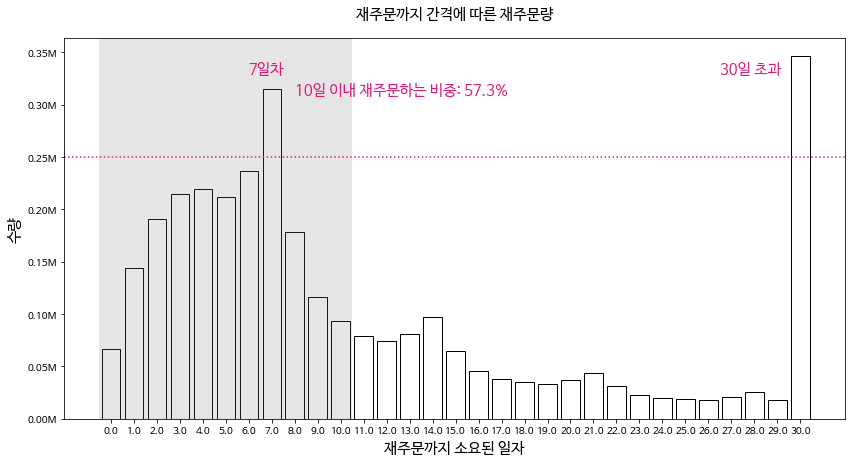

In [ ]:
plt.figure(figsize=(14,7))
g =sns.countplot(data=orders, x='days_since_prior_order', fill=False, color='black');
plt.axhline(y=250000, linestyle=':', color='#dd1c77');
ylabels =  ['{:,.2f}'.format(y) + 'M' for y in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)

plt.title('재주문까지 간격에 따른 재주문량', fontsize=15, pad=20);
plt.xlabel('재주문까지 소요된 일자', fontsize=15);
plt.ylabel('수량', fontsize=15);
plt.axvspan(-0.5, 10.5, facecolor='gray', alpha=0.2)
plt.text(6, 330000, '7일차', color='#dd1c77', fontsize=15);
plt.text(8, 310000, '10일 이내 재주문하는 비중: 57.3%', color='#dd1c77', fontsize=15);
plt.text(26.5, 330000, '30일 초과', color='#dd1c77', fontsize=15);

#### 2.2.1 - 2 **재주문 간격**이 짧을 수록 **이전 주문**에서 구매한 상품을 **재주문**할까?
* 재주문 상품 비율이 평균대비 높습니다.
* 평균적으로 10일 이내 주문시 재주문 상품비중이 평균대비 높지만, 큰 차이는 아닙니다. (5%미만 차이)

In [ ]:
reordered_since_days_ds = order_total.groupby(['days_since_prior_order','reordered']).agg({'product_id':len})
reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index='days_since_prior_order', columns='reordered', values='product_id')
reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] /reordered_since_days_ds.sum(axis=1)*100
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0,1]].sum().sum(),2) *100

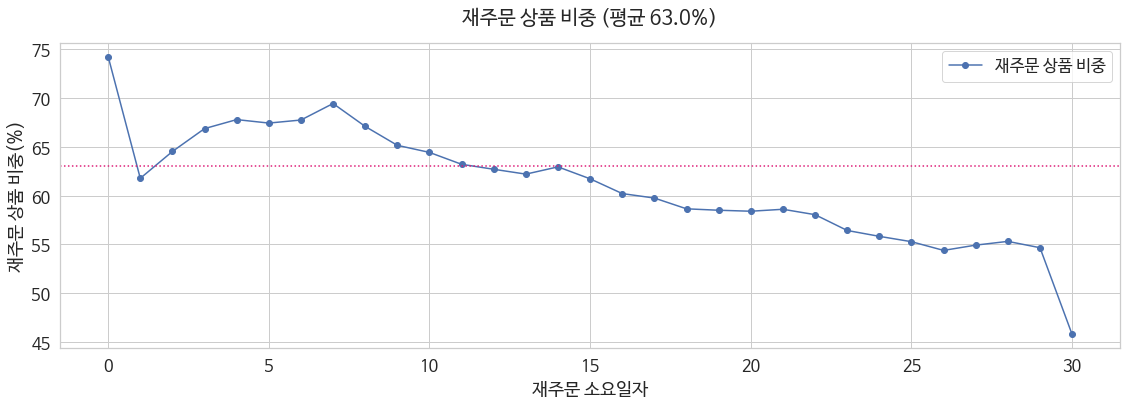

In [ ]:
reordered_since_days_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("재주문 상품 비중 (평균 {}%)".format(avg_reordered_rate), pad=20, fontsize=20)
plt.xlabel('재주문 소요일자')
plt.ylabel('재주문 상품 비중(%)')
plt.legend(labels=['재주문 상품 비중'])
plt.axhline(y=63, color="#dd1c77", linestyle=":")
plt.tight_layout()
plt.show()

### 2.2.2 **주문 횟수**

#### 2.2.2 -1  **주문 횟수**가 많아 질수록 **재주문 시점**이 빠를까? (그래프: 파랑)
* 그렇습니다. 
* 주문 횟수가 많다는 것은 고객충성도가 높다고 볼 수 있으므로, 재주문이 빨리 이루어질 것으로 예측 할 수 있습니다.



#### 2.2.2 -2 **주문 횟수**가 많아 질수록 주문당 **구매하는 상품수**가 많을까? (그래프: 노랑)
* 상관없이 주문 수량은 유사한 패턴을 보입니다.

In [ ]:
print('재주문까지 평균 소요시간: ',  round(orders.days_since_prior_order.mean(),2), '일')
print('재주문이 가장 많은 시점: ',  round(orders.days_since_prior_order.median(),2), '일차')

재주문까지 평균 소요시간:  10.97 일
재주문이 가장 많은 시점:  7.0 일차


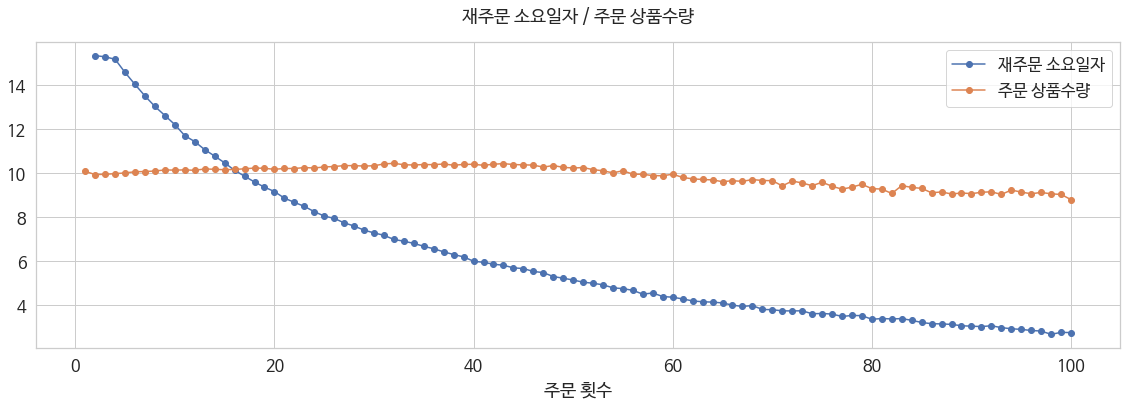

In [5]:
sns.set(style="whitegrid", font_scale=1.5, rc={'font.family':'NanumBarunGothic'})
orders.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean}).plot(figsize=(16,6), marker='o')
plt.title(label="재주문 소요일자 / 주문 상품수량", pad=20)
plt.legend(labels=['재주문 소요일자','주문 상품수량'])
plt.xlabel('주문 횟수')
plt.tight_layout()
plt.show()

### 2.2.3 **주문 수량**

#### 2.2.3 -1 **많은 수량**을 구매한 오더에는 **재주문 상품**이 많을까?
* 그렇습니다. 많은 물품을 주문하는 경우에는 기존 상품을 살 확률일 높습니다.
* **40개 이상 주문**한 경우 **재주문 상품비중이 80% 이상**입니다. 
* 많은 종류의 상품을 구매하는 사람들은 자주 구매하는 상품들이 고정적으로 있는 것으로 추정할 수 있습니다.

In [ ]:
reordered_order_num_ds = order_total.groupby(['order_number','reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index='order_number', columns='reordered', values='product_id')
reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] /reordered_order_num_ds.sum(axis=1) *100
avg_reordered_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0,1]].sum().sum(),2) *100
reordered_order_num_ds.fillna(0, inplace=True)

In [ ]:
reordered_order_num_ds.sort_values(by='reorder_rate', ascending=False).tail(10)

reordered,0,1,reorder_rate
order_number,,,
10,399048.0,689872.0,63.353782
9,455370.0,733464.0,61.696082
8,523581.0,771212.0,59.562571
7,610035.0,814761.0,57.184397
6,723852.0,853714.0,54.115898
5,870202.0,881757.0,50.329774
4,1075600.0,894580.0,45.406004
3,1258570.0,792161.0,38.628226
2,1490447.0,557885.0,27.236063


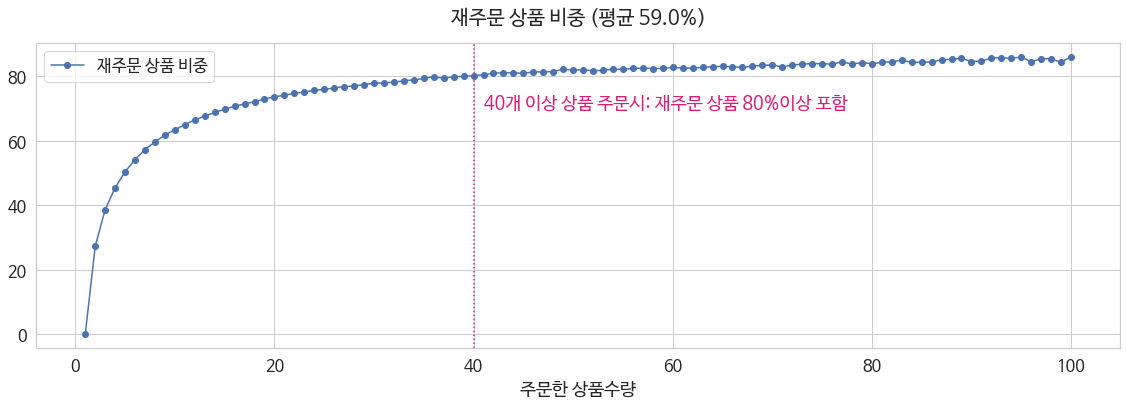

In [ ]:
reordered_order_num_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("재주문 상품 비중 (평균 {}%)".format(avg_reordered_rate), pad=20, fontsize=20)
plt.xlabel('주문한 상품수량')
plt.legend(labels=['재주문 상품 비중'])
plt.axvline(x=40, color="#dd1c77", linestyle=":")
plt.text(41, 70, "40개 이상 상품 주문시: 재주문 상품 80%이상 포함", color="#dd1c77")
plt.tight_layout()
plt.show()

#### 2.2.3 -2 주문이 많은 **인기상품의 재주문율**이 높은지?
* 당연합니다. 수치로 확인해보아도 양의 상관관계가 나옵니다.
* spearman 상관계수로 단조성(한 변수 값이 커지면 다른 변수도 커지는지)를 확인
* cf: pearson 상관계수로는 선형성(변수들 관계가 직선으로 모델링이 잘 된다)을 확인

In [ ]:
product_reorder_ds = order_total.groupby(['product_id']).agg({'order_id':len, 'reordered':lambda x: len(x[x>0]), 'user_id':lambda x: len(x.unique())})
# 상품당, 재구매건만 재주문 횟수, 재주문한 고객수 
convert_colnames = {'user_id':'unique_users','reordered':'reorder' , 'order_id':'total_order'}
product_reorder_ds.columns = [  convert_colnames[col] for col in product_reorder_ds.columns]
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order,2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order/product_reorder_ds.unique_users,2)
product_reorder_ds = product_reorder_ds.merge(products, left_index=True, right_on='product_id')

In [ ]:
from scipy.stats import spearmanr
anot = spearmanr(product_reorder_ds.reorder_rate,product_reorder_ds.total_order)
anot

SpearmanrResult(correlation=0.5825250081432025, pvalue=0.0)

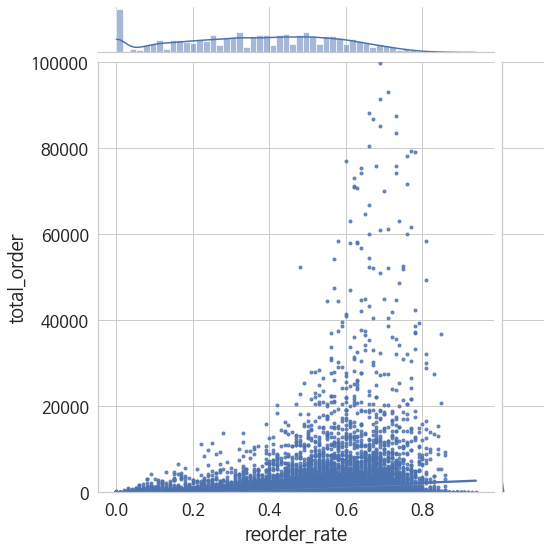

In [ ]:
g = sns.jointplot("reorder_rate", "total_order", kind="reg", marker='.', ylim=(0,100000), size=8, ratio=8
                  , data=product_reorder_ds);

### 2.2.4 **주문 상품 구성**

#### 2.2.4 -1 **재주문 비율**이 높은 상품은?
* 재주문 수량 자체가 많은 상품은 판매량 상위 상품과 유사합니다. (1위: 바나나)
* 동일 상품에서 총 주문량에 비해 재주문량이 많은지 비교하면 패턴이 달라집니다. (1위: 유제품)
* **우유 상품(84구역)**이 대부분을 차지하며, 83%의 높은 재주문 비율이 나타납니다.
* 우유이외는 바나나, 물 상품이 있습니다.
* 당연히 유저당 주문수도 비례하여 높습니다.

In [7]:
product_reorder_ds = order_total.groupby(['product_id']).agg({'order_id':len, 'reordered':lambda x: len(x[x>0]), 'user_id':lambda x: len(x.unique())})
# 상품당, 재구매건만 재주문 횟수, 재주문한 고객수 
convert_colnames = {'user_id':'unique_users','reordered':'reorder' , 'order_id':'total_order'}
product_reorder_ds.columns = [  convert_colnames[col] for col in product_reorder_ds.columns]
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order,2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order/product_reorder_ds.unique_users,2)
product_reorder_ds = product_reorder_ds.merge(products, left_index=True, right_on='product_id')

In [ ]:
# 재구매 수량 자체가 많은 상품
product_reorder_ds[product_reorder_ds.total_order>1000].sort_values('total_order', ascending=False)\
        [['product_name','total_order', 'reorder_rate', 'aisle_id','orders_per_user']][:10]

,product_name,total_order,reorder_rate,aisle_id,orders_per_user
24851,Banana,491291,0.85,24,6.45
13175,Bag of Organic Bananas,394930,0.83,24,6.02
21136,Organic Strawberries,275577,0.78,24,4.51
21902,Organic Baby Spinach,251705,0.77,123,4.43
47208,Organic Hass Avocado,220877,0.80,24,4.94
47765,Organic Avocado,184224,0.76,24,4.19
47625,Large Lemon,160792,0.70,24,3.31
16796,Strawberries,149445,0.70,24,3.33
26208,Limes,146660,0.68,24,3.14
27844,Organic Whole Milk,142813,0.83,84,5.92


In [ ]:
# 상품의 구매량에 비해 재구매량이 많은지
product_reorder_ds[product_reorder_ds.total_order>1000].sort_values('reorder_rate', ascending=False)\
        [['product_name','total_order', 'reorder_rate', 'aisle_id','orders_per_user']][:10]

,product_name,total_order,reorder_rate,aisle_id,orders_per_user
9291,Half And Half Ultra Pasteurized,2995,0.86,84,7.22
5513,Organic Homogenized Whole Milk,4095,0.86,84,7.05
43393,Organic Lactose Free Whole Milk,8742,0.86,91,7.10
47230,Ultra-Purified Water,1524,0.86,115,6.99
45503,Whole Organic Omega 3 Milk,9410,0.86,84,7.13
38688,Organic Reduced Fat Milk,36869,0.85,84,6.73
24851,Banana,491291,0.85,24,6.45
29446,"Milk, Organic, Vitamin D",20770,0.85,84,6.88
34196,Goat Milk,5353,0.85,84,6.67
39179,Organic Lowfat 1% Milk,15352,0.84,84,6.30


#### 2.2.4 -2 소분류 내에서 **재주문 상품 비율** 상위 항목 10개, 하위 10개?
* 상품군에 따라 재주문 비율이 다른지 살펴보면 **유통기간**에 따라 차이를 발견할 수 있습니다.
* 재주문 비율이 높은 상품: **유통기간이 짧은** 우유, 계란, 과일, 야채 등 신선 농산물 위주
* 재주문 비율이 낮은 상품: **유통기간이 긴** 상품 위주로 보입니다.

In [8]:
aisle_order_stat_ds = product_reorder_ds.groupby('aisle_id').agg({'total_order':sum, 'reorder':sum})
aisle_order_stat_ds['reorder_rate'] = round(aisle_order_stat_ds.reorder / aisle_order_stat_ds.total_order, 2) *100
aisle_order_stat_ds = aisle_order_stat_ds.merge(aisles, on='aisle_id').sort_values('reorder_rate', ascending=False)
aisle_order_stat_ds.index= aisle_order_stat_ds.aisle

In [9]:
def toReadable(num):
    value = round(num,2) if isinstance(num, float) else num #소수점 2자리까지만 사용

    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000,1))+'K'
    elif value >= 1000000:
        return str(round(value/1000000,1))+'M'
    return value

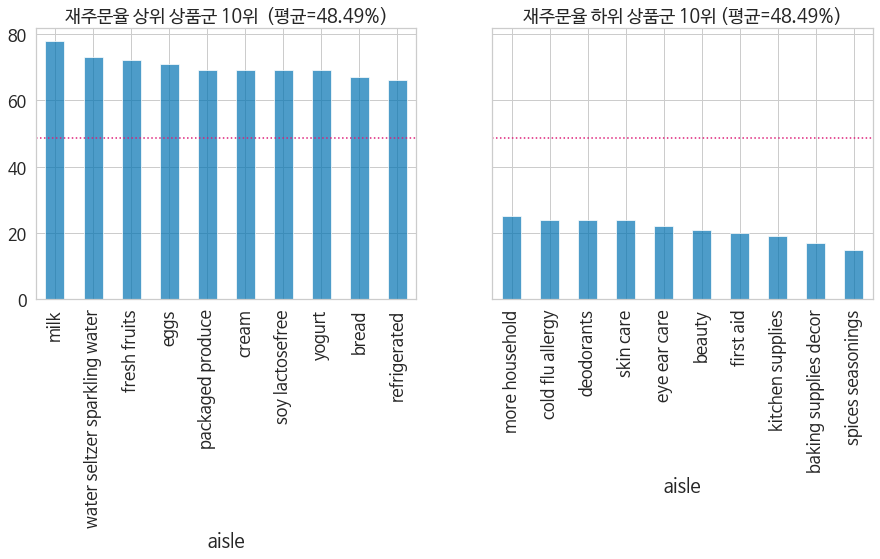

In [10]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1.5, rc={'font.family':'NanumBarunGothic'} )

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

top10_ds = aisle_order_stat_ds[['reorder_rate']][:10]
top10_ds.plot(kind='bar', figsize=(15,5), alpha=.7, ax=ax1
             , title='재주문율 상위 상품군 10위  (평균={}%)'.format(toReadable(aisle_order_stat_ds.reorder_rate.mean())))
ax1.axhline(y=48.5, linestyle=":", color='#dd1c77')
ax1.get_legend().remove()

bottom10_ds = aisle_order_stat_ds[['reorder_rate']][-10:]
bottom10_ds.plot(kind='bar', figsize=(15,5), alpha=.7, ax=ax2
                , title='재주문율 하위 상품군 10위 (평균={}%)'.format(toReadable(aisle_order_stat_ds.reorder_rate.mean())))
ax2.axhline(y=48.5, linestyle=":", color='#dd1c77')
ax2.get_legend().remove()

plt.show()

### 2.2.5 **주문 요일 및 시간**
* 시간과 요일, 두변수를 교차 시켜 살펴보고자 합니다.
* 변수가 많아 수치파악이 복잡할 수 있으므로 히트맵의 색상차이로 직관적으로 확인하기 쉽게 구성하여 검증합니다.
* 진한색이 수치(예: 주문량)가 높은 것을 말합니다.


#### 2.2.5 - 1 **주문 트렌드**는 어떤지? (재주문 / 재구매 상품)
* 모든 요일에 **09~17시** 사이 주문이 많습니다. (그래프에서 색이 진한 부분)
* 특히 **월요일**과 **화요일** 오전까지 주문이 많으며, 고객당 주문건수는 화요일 오전이 가장 많습니다.
* **재주문 수**와 **재주문 상품의 주문 갯수**로 비교해 봐도 패턴이 동일합니다.
* 전체 주문이 증가하는 것이며, 고객당 주문건수는 증감 차이가 적습니다.

In [ ]:
index_day =['월','화','수','목', '금', '토', '일'];

def drawWeekHour(ds, values,  aggfunc=len, title=None, figsize=(18,5) , cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_ds.index =  [ index_day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid", palette=cmap, font_scale=1, rc={'font.family':'NanumGothic'} )

    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap, alpha=0.7) 
    plt.xlabel("시간")
    plt.ylabel("요일")
    if title:
        plt.title(title, fontsize=15, pad=20)

시간과 요일에 따른 주문건 (2번째 주문부터 집계)

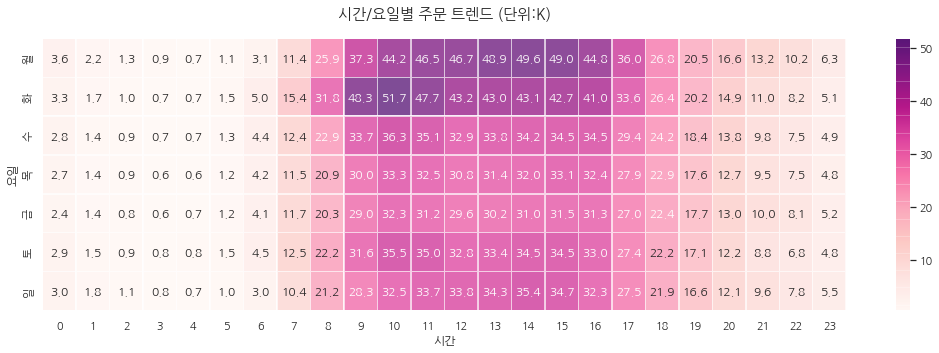

In [ ]:
drawWeekHour(orders[orders['order_number']>1], values='order_id', title="시간/요일별 주문 트렌드 (단위:K)",aggfunc=lambda x: len(x)/1000, cmap='RdPu')

시간과 요일에 따른 재주문 상품수

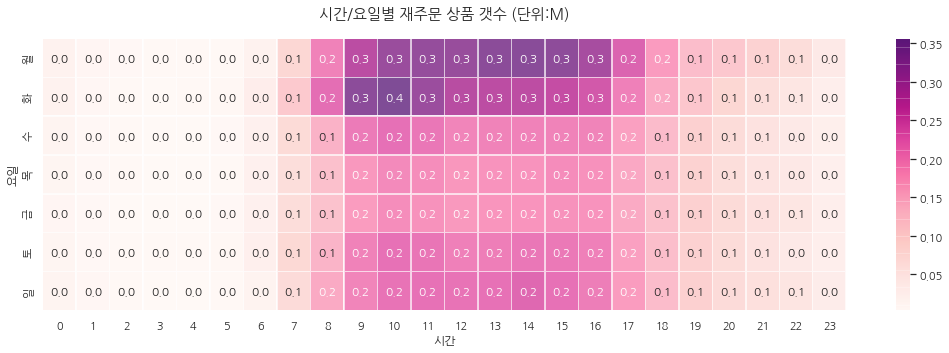

In [ ]:
drawWeekHour(order_total[order_total['reordered']==1], values='product_id', title="시간/요일별 재주문 상품 갯수 (단위:M)",aggfunc=lambda x: len(x)/1000000, cmap='RdPu')

시간과 요일에 따른 고객당 주문수

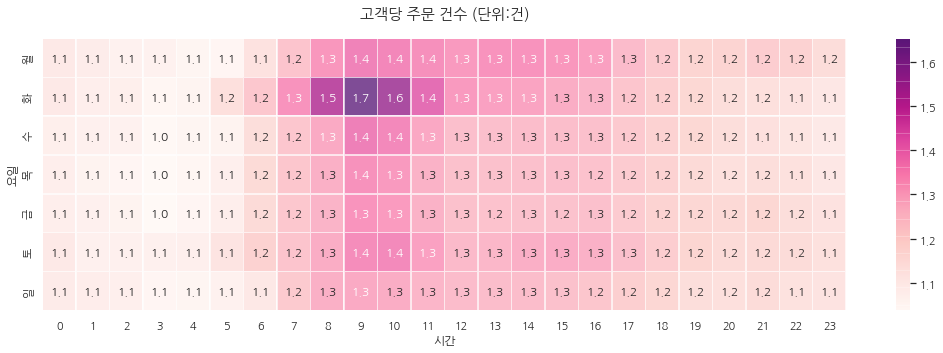

In [ ]:
drawWeekHour(orders, values='user_id', title="고객당 주문 건수 (단위:건)", aggfunc=lambda x: len(x)/len(x.unique()),cmap='RdPu')

#### 2.2.5 -2 재구매 상품 중 **구매 시간**에 따른 **판매 상위모델**에 차이가 있는가? 
* 1~5위 까지는 거의 변화가 없고, 6위 아래는 변화가 있습니다.
* 구매가 집중된 9시~17시 구간과 그 외 시간의 구매 상품이 많이 다릅니다.

In [ ]:
def topItemEachGroup(ds, group_name, sort_name, topn):
    concat_list = []
    for (key, rows) in ds.groupby(group_name):
        sub_ds = rows.sort_values(sort_name, ascending=False)[:topn]
        sub_ds['rank'] = list(range(1,topn+1))
        concat_list.append(sub_ds)

    return pd.concat(concat_list)

In [ ]:
def drawRankTrend(pivot_ds, ylabel='Rank'):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.3, rc={'font.family':'NanumGothic'} )

    index_max = pivot_ds.index.max()
    rank_max = pivot_ds.max().max()
    pivot_ds = pivot_ds.applymap(lambda x:rank_max-x+1)
    pivot_ds.plot(marker='o', figsize=(15,10), cmap='Dark2', xticks=pivot_ds.index, legend=None )
    
    plt.yticks(np.arange(rank_max,0,-1), np.arange(1,rank_max+1))
    for name, rank in pivot_ds.loc[index_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(index_max*1.09,rank,name)
        plt.axvspan(9, 17, facecolor='#f0f0f0', alpha=0.1)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
hour_product_ds = order_total[order_total['reordered']==1].groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':len})
hour_top_product_ds = topItemEachGroup(hour_product_ds, 'order_hour_of_day', 'order_id' , 20)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', columns='product_name', values='rank') 

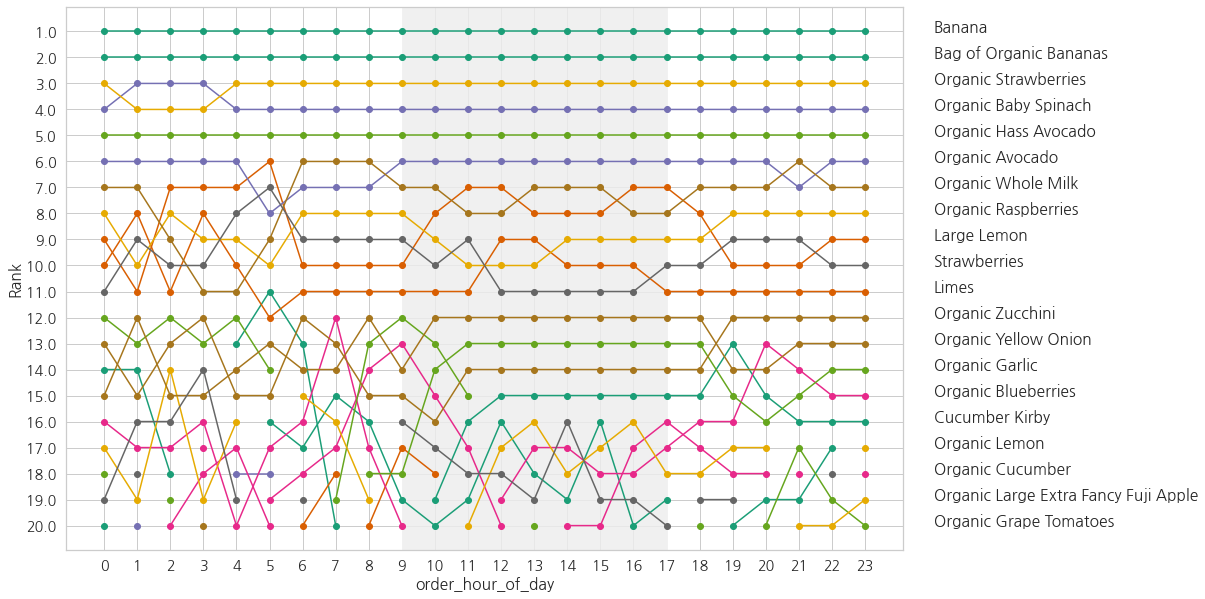

In [ ]:
drawRankTrend(hour_top_product_pivot_ds)

#### 2.2.5 -3 재주문 한번에 **구매하는 상품이 많은** 시간/요일은?
* **늦은 밤**(21~23시) 구매시 상품구매 수량이 많습니다.
* 주문량이 많은 **월,화**와 주말인 **일**에 주문 수량이 많은 편입니다.

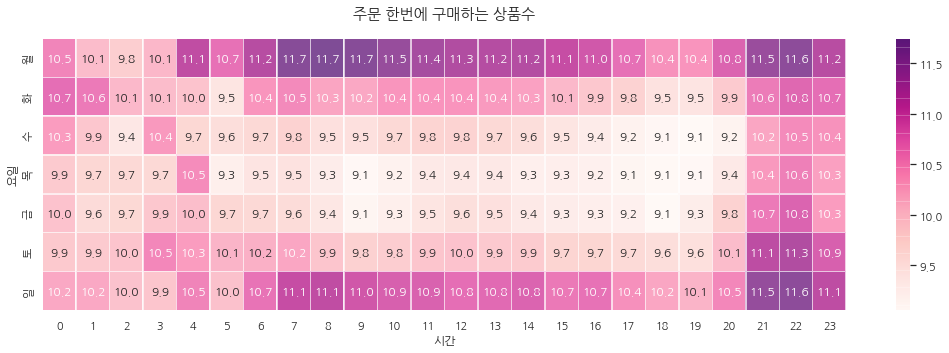

In [ ]:
drawWeekHour(orders[orders['order_number']>1], values='product_cnt', title="주문 한번에 구매하는 상품수", aggfunc=lambda x: np.mean(x), cmap='RdPu')

#### 2.2.5 -4 **재주문**까지 걸리는 시간은?
* 수치가 작을 수록 금방 재주문을 했다는 의미이고, 자주 주문함을 의미합니다. 진한 색이 재주문이 오래 걸렸다는 의미입니다.
* **새벽시간** 구매는 이전 주문 이후 오랜만에 구매한 경우가 많습니다. 
    * 오랜만에 필요한 상품을 늦은 시간이라도 주문하거나 충동구매로 추측할 수 있습니다.
    * 구매한 **상품**을 보면, 일반주문에 비해 **냉동식품**, **통조림식품** 순위가 높습니다.
* 새벽시간에 구매하는 **고객**들을 추가로 살펴보면, 새벽시간에만 구매하는 패턴이 있는 것은 아닙니다. 
    * 새벽시간에 구매한 기록이 있는 고객의 전체 주문을 살펴보면 보통 주문이 많은, 09~17시 사이 주문이 동일하게 많습니다.


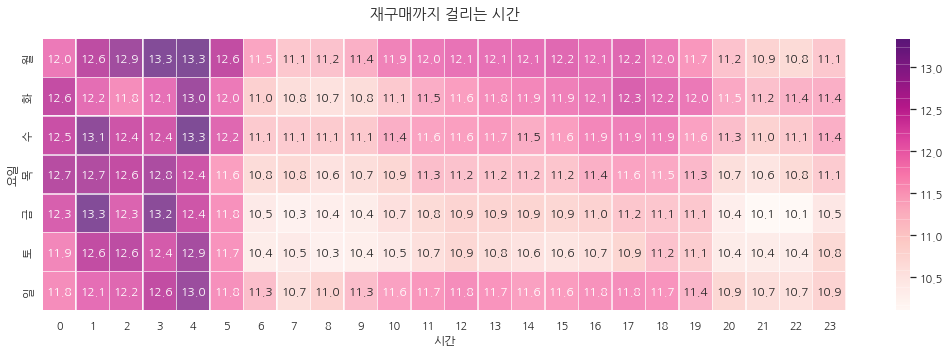

In [ ]:
drawWeekHour(order_total, values='days_since_prior_order', title="재구매까지 걸리는 시간", aggfunc=lambda x: np.mean(x))

In [ ]:
# 새벽에 주문한 이력이 있는 고객의 구매내역
late_order = (order_total['order_hour_of_day']>=0) & (order_total['order_hour_of_day']<=5) # 0~5시에 주문한 오더
late_order_user = order_total[late_order]['user_id'] #위의 조건에 맞는 유저
late_order_list = order_total['user_id'].isin(late_order_user) #새벽주문을 했던 유저의 오더목록
late_order_list_p = order_total[late_order_list]
late_order_list_p = late_order_list_p.drop_duplicates(['order_id'], keep='last')

In [ ]:
# 새벽시간에 구매한 상품은 다른가
late_order_list_p.pivot_table(index='department', columns='aisle', values='order_id', aggfunc=len, margins=True).fillna(0).sort_values(by='All', ascending=False).head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,All
department,,,,,,,,,,,,,,,,,,,,,
All,912.0,9239.0,2082.0,1835.0,34652.0,738.0,3539.0,269.0,77.0,2984.0,...,10338.0,5496.0,2059.0,352.0,1831.0,972.0,31258.0,3504.0,1492.0,846127
frozen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193717
canned goods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143683
beverages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10338.0,0.0,0.0,0.0,0.0,0.0,31258.0,0.0,0.0,97399
produce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52464
deli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50977
babies,0.0,0.0,2082.0,1835.0,34652.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43563
dry goods pasta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42341
household,912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1831.0,0.0,0.0,0.0,0.0,38613


In [ ]:
# 전체 주문
order_total.pivot_table(index='department', columns='aisle', values='order_id', aggfunc=len, margins=True).fillna(0).sort_values(by='All', ascending=False).head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,All
department,,,,,,,,,,,,,,,,,,,,,
All,20918.0,173614.0,8466.0,8909.0,395654.0,36372.0,339780.0,24786.0,6455.0,50496.0,...,258717.0,134597.0,201650.0,37053.0,33702.0,47028.0,878150.0,31646.0,1507583.0,33819106
produce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9888378
dairy eggs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1507583.0,5631067
snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,37053.0,0.0,0.0,0.0,0.0,0.0,3006412
beverages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,258717.0,0.0,0.0,0.0,0.0,0.0,878150.0,0.0,0.0,2804175
frozen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2336858
pantry,0.0,0.0,0.0,0.0,0.0,0.0,339780.0,24786.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1956819
bakery,0.0,0.0,0.0,0.0,0.0,36372.0,0.0,0.0,0.0,0.0,...,0.0,0.0,201650.0,0.0,0.0,0.0,0.0,0.0,0.0,1225181
canned goods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1114857


In [ ]:
late_order_table = late_order_list_p['order_hour_of_day'].value_counts().reset_index(drop=False)
late_order_table.columns = [['order_hour_of_day','order_cnt']]
late_order_table['%'] = round(late_order_table['order_cnt']/ late_order_table['order_cnt'].sum(),3)*100
late_order_table[:24]

,order_hour_of_day,order_cnt,%
0,15,60108,7.1
1,14,59798,7.1
2,11,59780,7.1
3,13,59222,7.0
4,16,59129,7.0
5,12,58570,6.9
6,10,58540,6.9
7,17,53165,6.3
8,9,52192,6.2
9,18,45813,5.4


# 3. 대시보드를 통한 편리한 데이터 확인 
* https://datastudio.google.com/reporting/cc65e16c-d117-4770-8211-6046d79d1af4
* 위의 분석내용중 대표적인 항목만 간단히 **대시보드**를 구성하였습니다.
* 구글 **데이터스튜디오**로 구성하였으며, 분석자료 크기제한(100MB)이 있어 데이터를 **샘플링**하여 진행하였습니다. 
* 구성된 항목은 동일하며, 수치가 샘플링 된 기준으로 차이가 있습니다.
* 이커머스에서 구글 애널리틱스(GA) 활용도가 높고, 이를 데이터스튜디오로 시각화하면 맞춤 보고서를 만들기 편리하여 선택하였습니다.
* 매일 확인하는 실적으로 구성했다고 가정하고, 출력하여 활용하기 쉽도록 A4 비율에 맞추어 작업하였습니다.

# 4. EDA 및 가설검증에서 얻은 마케팅 인사이트
* 분석 결과를 토대로 고객 특성에 맞게 **재주문을 독려**하는 방안을 마련합니다.
* **고객의 타겟팅**을 강화하여 **마케팅 활동을 결정** 할 수 있습니다.
* 이후 고객별 구매한 상품목록을 추가로 분석하여 **상품추천**을 향상 시키고자 합니다. 

### 가설 검증 결과: **재주문**에 **패턴**이 존재한다. →  **Yes!**
* 어떤 패턴이 있는지? **주문 간격 / 주문 횟수 / 주문 수량 / 주문 상품 구성 / 주문 요일 및 시간** 



#### 1. 주문 간격: **7일** (~10일 이내)  
* 고객 타겟 판촉일정을 맞춥니다. **메일링,문자로 판촉**내용을 알리는 주기를 **7일**, 30일로 합니다.  


#### 2. 주문 횟수: **주문 횟수**가 많으면 당연히 재주문 시점이 빠르다. **구매 수량은 비슷**하다.
* 주문 **빈도**에 따른 고객 관리가 필요합니다.  
    → 평균적으로 **4회** 주문이 가장 많고, 5회부터 감소 추세  
    → 4회 이상과 이하 이용 고객을 분리하여 관리합니다. 초기에 지속적인 구매를 독려하는 것이 중요합니다.  
    → 이용 횟수 **10회 단위**로 고객을 구분하여, 구매 적립포인트를 다르게 하는 등 차별화된 이점을 줍니다.  
    → **상위 10% (40회 이상 구매고객)** 을 밀착 관리하고, 이용 후기나 요청 사항에 빠르게 피드백합니다.  


  
#### 3. 주문 수량: **많은 수량**을 구매하는 경우 **재주문 상품 비중이 높다**.

주문 수량 | 재주문 상품 비중
----------| ----------------
5개       |   50%
10개      |   63%
40개 이상 |   80%  
  
* 주문 수량에 따라 다른방식으로 추천합니다.  
    → **평균(4~7개)보다 적을 때**, 장바구니 상품과 연관성 있는 상품을 추천하고 세트 구매를 독려합니다.  
    → **많은 수량을 구매** 하는 사람에게는 구매했던 상품을 중심으로 추천합니다.  
    → 주문이 많은 인기상품과 재주문 비중이 높은 상품을 중점적으로 추천합니다.
        
#### 4. 주문 상품 구성: **유통기간** 짧은 상품의 재주문이 많다.
* **유통기간**에 따라 한번에 구매하는 양이 달라집니다.   
    → 보관이 편한 상품은 수량을 증가시켜 상품을 구성합니다.  
    → 조금씩 자주 구매 해야 하는 상품은, 기존 구매 상품을 먼저 추천합니다.

#### 5. 주문 요일 및 시간: **월,화, 9~17시** 주문이 많다. 구매 **시간**에 따른 구매패턴이 다르다.  
* 상황에 맞는 판촉을 계획합니다.  
    → 이전 주문한지 오래된 고객에게 판촉하는 경우 사람들이 구매가 많은 **월화, 9~17시 사이**에 합니다.  
    → **밤**에는 구매하는 수량이 많은편으로, 총 금액에 따른 할인을 운영하여 수량을 증가시키는 판촉을 합니다.  
    → **새벽**구매는 냉동식품, 통조림구매가 많습니다. 시간에 따른 구매패턴에 맞춰 상품을 추천합니다.



         